In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import json
import seaborn as sns
from sklearn import linear_model
import sklearn as sk
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import mixedlm
import statsmodels as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats as ss
from scipy import stats
import scipy.io as sio
from statsmodels import robust
from itertools import product
import statsmodels.formula.api as smf
%matplotlib inline

In [2]:
#get rid of scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', None)

## Import files

In [4]:
noprescreen = pd.read_csv('noprescreen_dataset/fish_v2_20.csv', sep = ",")

In [5]:
prescreen = pd.read_csv('apathy_dataset/fish_prescreen_v2_20.csv', sep = ",")

In [81]:
demographics_prescreen = pd.read_csv('apathy_dataset/demographics_apathy.csv', sep = ",")

In [82]:
demographics_noprescreen = pd.read_csv('noprescreen_dataset/demographics_v2_20.csv', sep = ",")

In [83]:
demographics = pd.concat([demographics_noprescreen, demographics_prescreen])

In [6]:
fish = pd.concat([noprescreen, prescreen])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [84]:
len(demographics.groupby('id').nunique())

40

In [8]:
scale_noprescreen = pd.read_csv('noprescreen_dataset/scale_fisherman2_noprescreening.csv', sep = ",")

In [9]:
scale_prescreen = pd.read_csv('apathy_dataset/scale_fisherman2_prescreen.csv', sep = ",")

In [10]:
scale = pd.concat([scale_noprescreen, scale_prescreen])

# Visualization

In [11]:
graph = fish.groupby(["price_displayed", "function_id"])['latency'].mean().reset_index()
graph.columns = ['price_displayed', 'function_id', 'average_latency']

In [12]:
price = [0.1, 0.4, 1, 2.5,  5.1, 6. ]
latency_l = graph.average_latency[(graph.function_id == 'fishing_l')]
latency_h = graph.average_latency[(graph.function_id == 'fishing_h')]

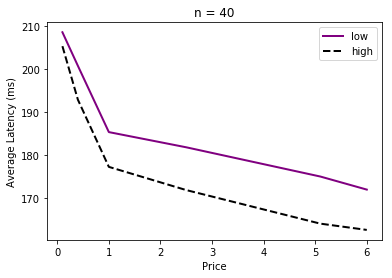

In [13]:
plt.plot( price, latency_l, marker='', color='purple', linewidth=2, label = "low")
plt.plot( price, latency_h, marker='', color='black', linewidth=2, linestyle='dashed', label="high")
plt.title("n = 40")
plt.xlabel("Price")
plt.ylabel("Average Latency (ms)")
plt.legend()
plt.savefig('figure/combined/v2.0_price_latency.png', transparent=True, dpi=300)

In [14]:
plot = fish.groupby(['id', 'price_displayed', 'environment'])['latency'].mean().reset_index(name = 'average_latency')


<Figure size 7200x8640 with 0 Axes>

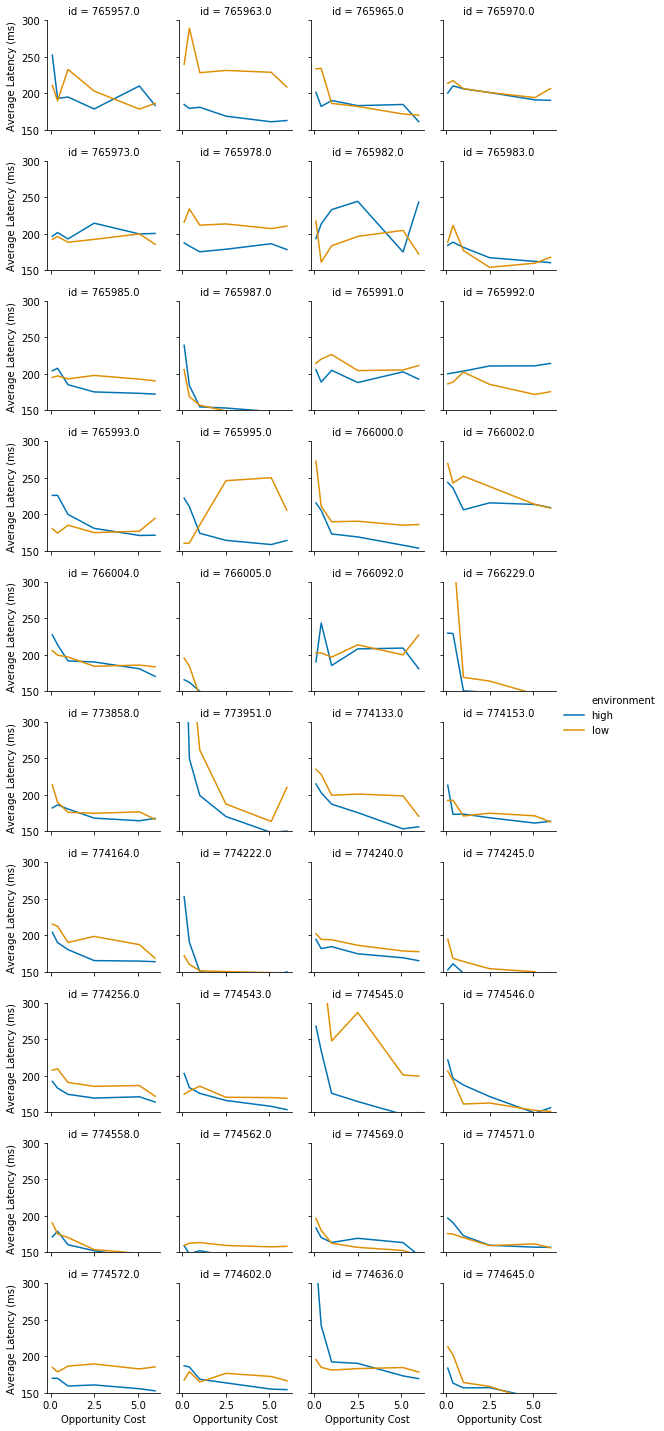

In [15]:
plt.figure(figsize=(100,120))
g = sns.FacetGrid(plot, col="id", col_wrap=4, height=2, ylim=(150, 300))
g.map(sns.lineplot,'price_displayed','average_latency', 'environment', palette = "colorblind", legend = 'full',
      err_style="bars")
g.add_legend()
g.set_axis_labels('Opportunity Cost', 'Average Latency (ms)')
plt.savefig('figure/combined/v2_By subject price and latency.png', dpi = 600, transparent = True)

In [16]:
plot = plot.merge(scale, on = ['id'], how = 'inner')

In [17]:
plot = plot.sort_values(by = 'bAMI')

In [25]:
plot['title'] = plot[['id', 'bAMI']].apply(lambda x: ' bAMI:'.join(x.astype(str)), axis=1)

<Figure size 7200x8640 with 0 Axes>

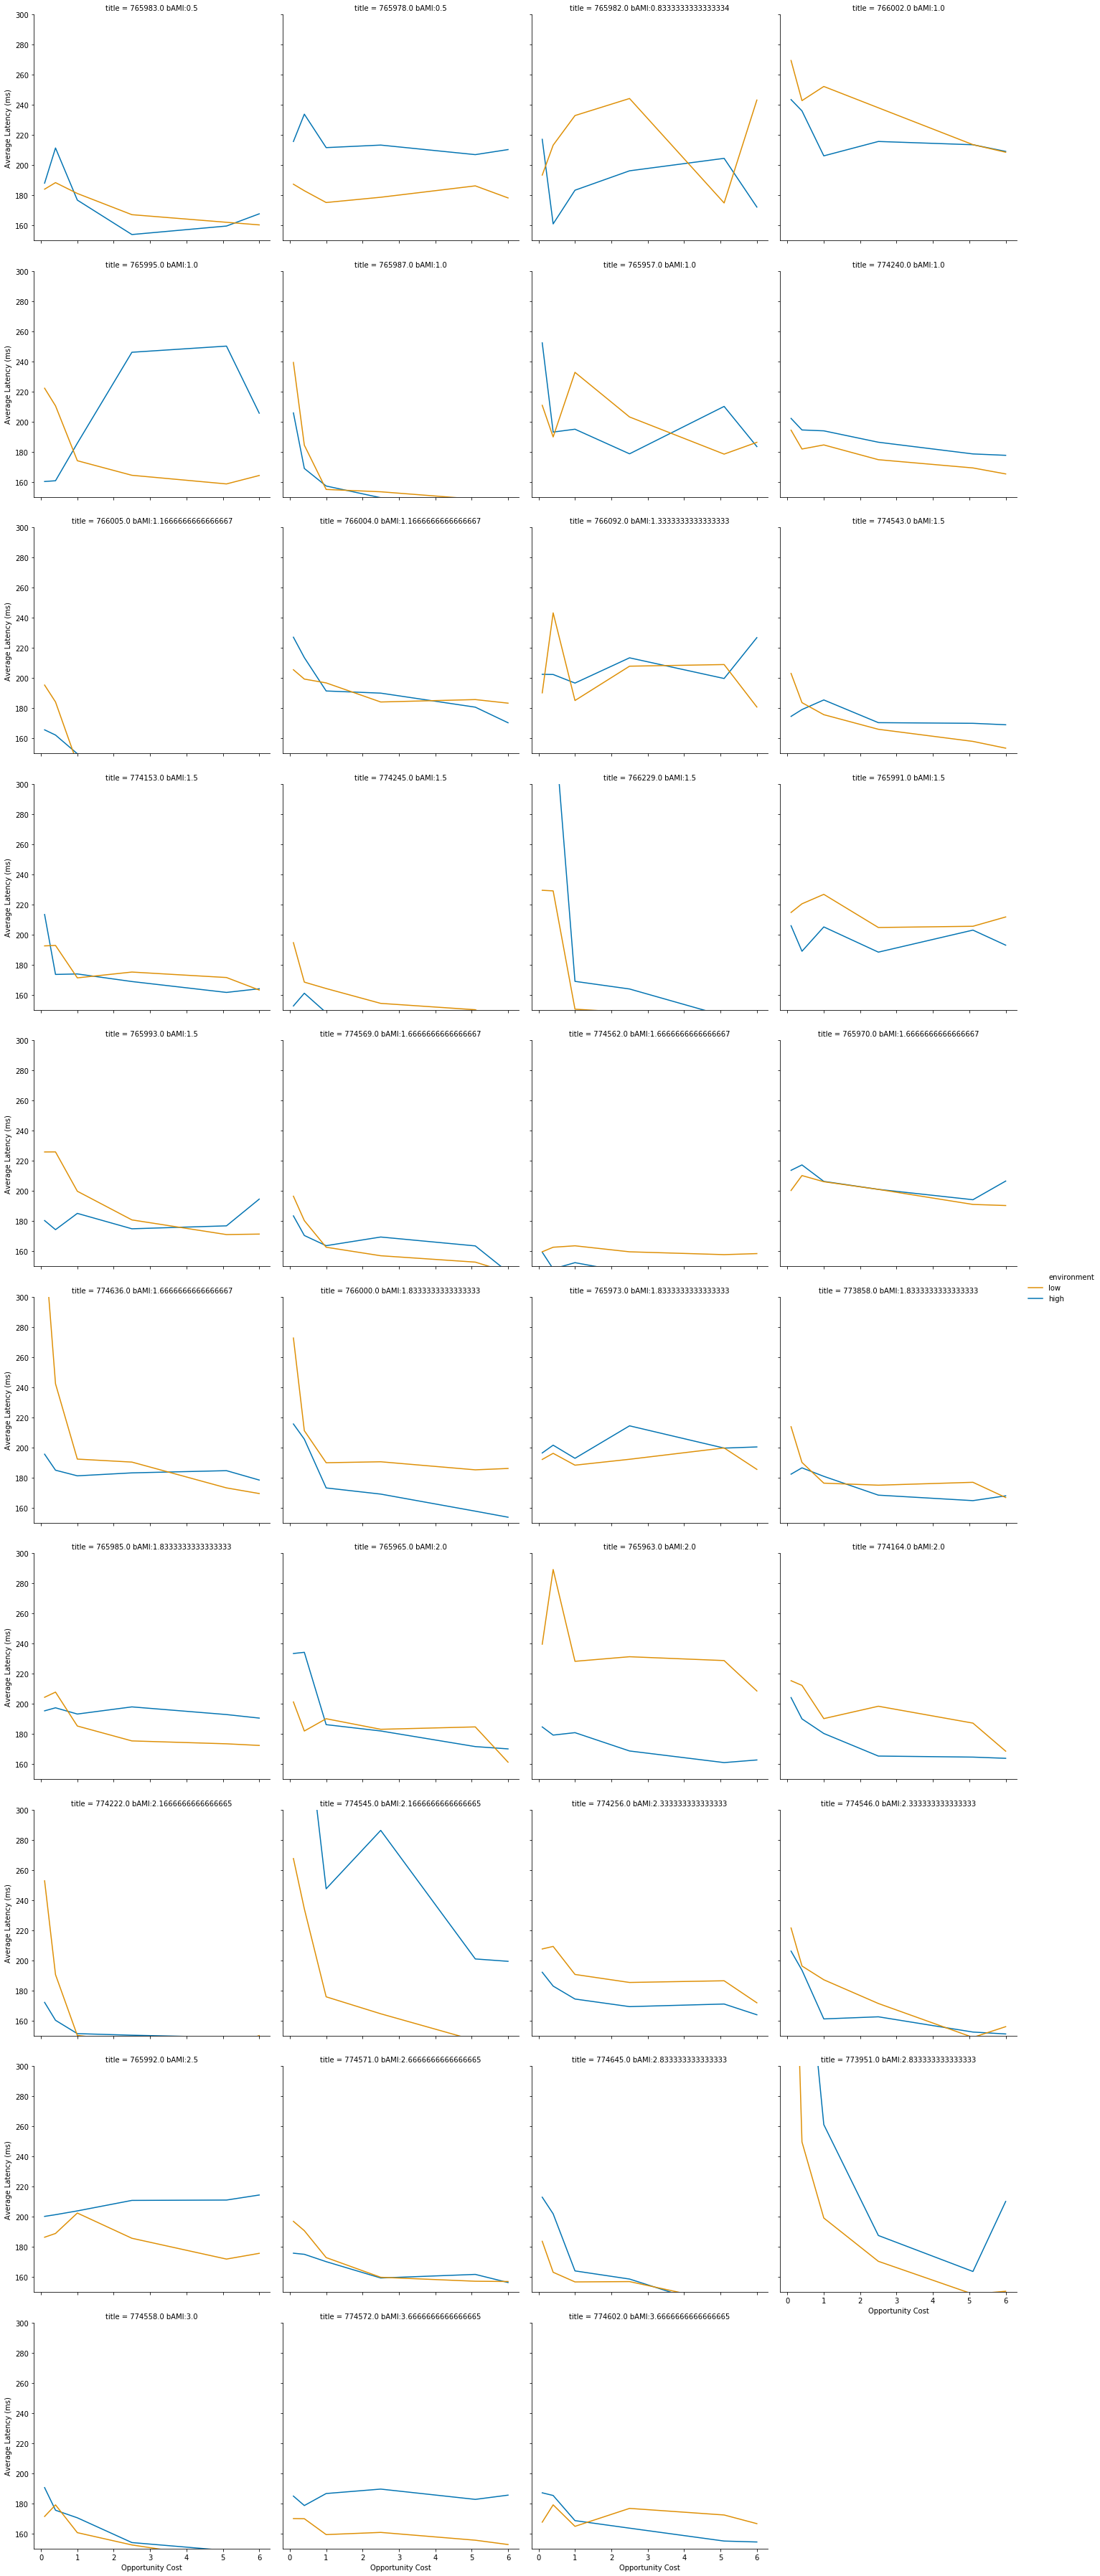

In [29]:
plt.figure(figsize=(100,120))
g = sns.FacetGrid(plot, col="title", col_wrap=4, height=5, ylim=(150, 300))
g.map(sns.lineplot,'price_displayed','average_latency', 'environment', palette = "colorblind", legend = 'full',
      err_style="bars")
g.add_legend()
g.set_axis_labels('Opportunity Cost', 'Average Latency (ms)')
plt.savefig('figure/combined/v2_By ami subject price and latency.png', dpi = 600, transparent = True)

# Normalization

In [18]:
data_low_highest = fish[(fish.environment == 'low')&(fish.price_displayed == 1)]
low_median = data_low_highest.groupby('id')['latency'].median().reset_index(name = 'median_latency')
low_median['median_latency']
# the equivalent of 2.5 in low env is 0.3 in high environment
data_high_equal = fish[(fish.environment == 'high')&(fish.price_displayed == 0.1)]
high_median = data_high_equal.groupby('id')['latency'].median().reset_index(name = 'median_latency')

In [19]:
ss.wilcoxon(low_median['median_latency'], high_median['median_latency'])

WilcoxonResult(statistic=236.0, pvalue=0.031599856439384746)

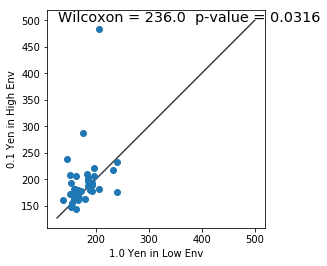

In [20]:
#For normalization, just do a scatterplot across your 100 subjects 
#of median latency 
#for the highest reward in low env vs the equivalent in high env. 
#If 2/3 are on one side of the line, it's an issue.

# Highest reward in low envrionemnt (0.5 pound worth 3000 yen) 2.5 
fig, ax = plt.subplots()
ax.scatter(low_median['median_latency'], high_median['median_latency'])
ax.set_xlabel('1.0 Yen in Low Env')
ax.set_ylabel('0.1 Yen in High Env')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
plt.annotate('Wilcoxon = 236.0  p-value = 0.0316', xy=(0.05, 0.95), xycoords='axes fraction', size = 'x-large')
ax.plot(lims,lims, 'k-', alpha=0.75, zorder=0)
plt.savefig('figure/combined/normalization_v2.0.png', transparent=True, dpi=300)
ax.set_aspect('equal')
# people tap faster in the low environment --> maybe there is a price effect

# Linear regression with predictor fatigue

In [21]:
fish['tap_count']=[1]*len(fish)
# fatigue per environment

In [22]:
fish['fatigue'] = fish.groupby(['id', 'environment'])['tap_count'].transform('cumsum')

# Linear Mixed Model

In [64]:
fish.isnull().sum()
fish = fish[fish.latency.notnull()]

In [65]:
fish['environment_binary'] = np.where(fish['environment']=='low', 0, fish['environment'])
fish['environment_binary'] = np.where(fish['environment']=='high', 1, fish['environment'])
fish['environment_binary'] = np.where(fish['environment']=='low', 0, fish['environment_binary'])
fish['environment_binary'] = np.where(fish['environment']=='high', 1, fish['environment_binary'])
fish['log_latency'] = np.log(fish['latency'])


In [66]:
f_model = mixedlm(formula = 'log_latency ~ 1 + environment_binary + price_displayed + fatigue',
                  groups = fish['id'],
                  re_formula = "~environment_binary + price_displayed + fatigue",
                  data = fish)

r = f_model.fit(reml = False, method = 'powell')


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [67]:
print (r.summary())

                          Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           log_latency
No. Observations:             131619            Method:                       ML         
No. Groups:                   40                Scale:                        0.0566     
Min. group size:              2637              Likelihood:                   1824.4399  
Max. group size:              3992              Converged:                    Yes        
Mean group size:              3290.5                                                     
-----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                      5.218    0.025 208.822 0.000  5.169  5.267
environment_binary[T.1]             

In [68]:
pd.DataFrame(r.params,columns=['LMM'])
random_effects = pd.DataFrame(r.random_effects)
random_effects = random_effects.transpose()
random_effects = random_effects.rename(index=int, columns={'groups': 'LMM'})

In [69]:
random_effects

,Group,environment_binary[T.1],price_displayed,fatigue
765957,0.041,0.027,0.003,-0.000
765963,0.202,-0.250,0.005,0.000
765965,0.031,0.009,-0.005,0.000
765970,0.043,0.024,0.010,0.000
765973,-0.055,0.080,0.024,0.000
765978,0.096,-0.112,0.026,-0.000
765982,-0.069,0.107,0.025,-0.000
765983,-0.121,0.075,0.004,0.000
765985,0.047,-0.021,0.016,-0.000
765987,-0.173,0.071,0.007,-0.000


In [70]:
x = random_effects['environment_binary[T.1]']
y = random_effects['price_displayed']
ss.pearsonr(x, y)

(0.39135045196663304, 0.01252055922960276)

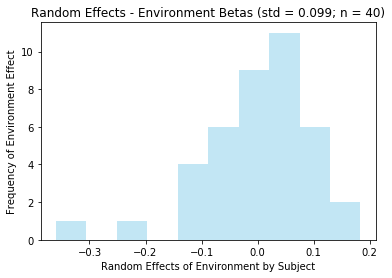

In [35]:
x = random_effects['environment_binary[T.1]']
plt.hist(x, alpha=0.5, label='x', color = 'skyblue')
plt.title('Random Effects - Environment Betas (std = 0.099; n = 40)')
plt.xlabel('Random Effects of Environment by Subject')
plt.ylabel('Frequency of Environment Effect')
plt.savefig('figure/combined/environment_beta_40.png', transparent=True, dpi=300)

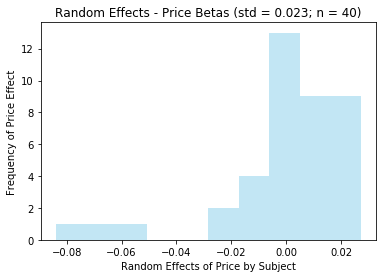

In [36]:
x = random_effects['price_displayed']
plt.hist(x, alpha=0.5, label='x', color = 'skyblue')
plt.title('Random Effects - Price Betas (std = 0.023; n = 40)')
plt.xlabel('Random Effects of Price by Subject')
plt.ylabel('Frequency of Price Effect')
plt.savefig('figure/combined/price_beta_40.png', transparent=True, dpi=300)

In [31]:
f_model_1 = mixedlm(formula = 'log_latency ~ 1 + environment_binary + price_displayed + fatigue +price_displayed*environment_binary',
                  groups = fish['id'],
                  re_formula = "~environment_binary + price_displayed + fatigue+price_displayed*environment_binary",
                  data = fish)

r_1 = f_model_1.fit(reml = False, method = 'powell')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [32]:
print (r_1.summary())

                                      Mixed Linear Model Regression Results
Model:                                MixedLM                   Dependent Variable:                   log_latency
No. Observations:                     131619                    Method:                               ML         
No. Groups:                           40                        Scale:                                0.0558     
Min. group size:                      2637                      Likelihood:                           2717.9359  
Max. group size:                      3992                      Converged:                            Yes        
Mean group size:                      3290.5                                                                     
-----------------------------------------------------------------------------------------------------------------
                                                                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------

In [160]:
pd.DataFrame(r_1.params,columns=['LMM'])
random_effects_1 = pd.DataFrame(r_1.random_effects)
random_effects_1 = random_effects_1.transpose()
random_effects_1 = random_effects_1.rename(index=int, columns={'groups': 'LMM'})

In [161]:
random_effects_1.describe()

,Group,environment_binary[T.1],price_displayed,price_displayed:environment_binary[T.1],fatigue
count,40.000,40.000,40.000,40.000,40.000
mean,-0.000,0.000,0.000,-0.000,-0.000
std,0.172,0.138,0.031,0.025,0.000
min,-0.237,-0.481,-0.091,-0.081,-0.000
25%,-0.104,-0.061,-0.013,-0.011,-0.000
50%,-0.039,-0.006,0.006,0.004,0.000
75%,0.063,0.080,0.018,0.014,0.000
max,0.605,0.286,0.070,0.046,0.000


## Environment Betas

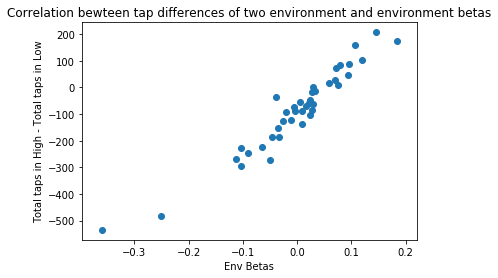

In [75]:
tap = fish.groupby(['id', 'environment'])['tap_count'].sum().reset_index(name = 'difference')
tap = tap.groupby(tap.index//2)['difference'].diff(-1).dropna().reset_index()

y = -1*tap['difference']
x = random_effects['environment_binary[T.1]']
plt.title('Correlation bewteen tap differences of two environment and environment betas')
plt.xlabel('Env Betas')
plt.ylabel('Total taps in High - Total taps in Low')
plt.scatter(x, y)

# Correlation with scales

In [37]:
scale = scale.drop('Unnamed: 0', axis = 1)

In [38]:
random_effects = random_effects.reset_index()

In [39]:
random_effects['id'] = random_effects['index']

In [40]:
corr = pd.merge(scale, random_effects, on = ['id'], how = 'inner')

In [63]:
x = corr['environment_binary[T.1]']
y = corr['price_displayed']
ss.spearmanr(x,y)

SpearmanrResult(correlation=0.07914979757085021, pvalue=0.6319663950876567)

### env & bAMI

In [72]:
x = corr['environment_binary[T.1]']
y = corr['bAMI']
ss.spearmanr(x,y)

SpearmanrResult(correlation=-0.07319000957463043, pvalue=0.6579139240018634)

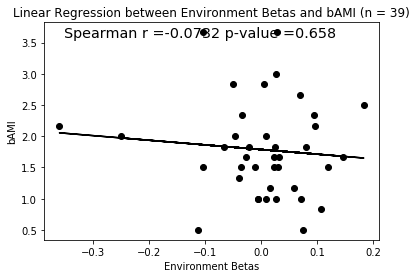

In [42]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept

plt.xlabel("Environment Betas")
plt.ylabel("bAMI")

plt.plot(x,y,'o',x,line,color = 'black')
plt.title('Linear Regression between Environment Betas and bAMI (n = 39)')
plt.annotate('Spearman r =-0.0732 p-value =0.658', xy=(0.06, 0.93), xycoords='axes fraction', size = 'x-large')

plt.savefig('figure/combined/env_bAMI_v2.0.png', transparent=True, dpi=300)
#plt.scatter(x, y, linewidth=2, color='purple', linestyle='-', marker='o', label="y=x^2")

### price & bAMI

In [73]:
x = corr['price_displayed']
y = corr['bAMI']
ss.spearmanr(x,y)

SpearmanrResult(correlation=-0.37662359093611913, pvalue=0.01811558750936537)

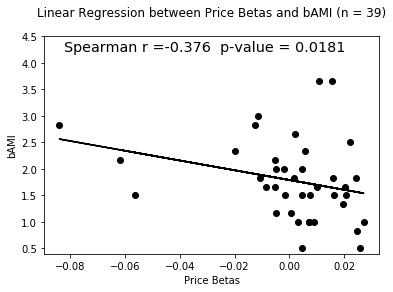

In [74]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept

plt.xlabel("Price Betas")
plt.ylabel("bAMI")

plt.plot(x,y,'o',x,line,color = 'black')
plt.title('Linear Regression between Price Betas and bAMI (n = 39)', pad = 20)
plt.ylim(0.40, 4.5)
plt.annotate('Spearman r =-0.376  p-value = 0.0181', xy=(0.06, 0.93), xycoords='axes fraction', size = 'x-large')

plt.savefig('figure/combined/price_bAMI_v2.0.png', transparent=True, dpi=300)
#plt.scatter(x, y, linewidth=2, color='purple', linestyle='-', marker='o', label="y=x^2")

In [75]:
r_value, p_value

(-0.2826554362872196, 0.08124587105507775)

## Regression model control for age and gender and HADS

In [86]:
corr = pd.merge(demographics, corr, on = ['id'], how = 'inner')

In [89]:
corr = corr.drop(['Unnamed: 0'], axis = 1)

In [101]:
model_bAMI_price = smf.ols('bAMI ~ depression + anxiety + price_displayed', data=corr)
model_bAMI_price = model_bAMI_price.fit()
model_bAMI_price.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   bAMI   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     4.967
Date:                Tue, 16 Jul 2019   Prob (F-statistic):            0.00563
Time:                        16:35:05   Log-Likelihood:                -37.157
No. Observations:                  39   AIC:                             82.31
Df Residuals:                      35   BIC:                             88.97
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.1889      0.240      4.960      0.000       0.702       1.676
depression          0.0838      0.039      2.157      0.038       0.005       0.163
anxiety             0.0299      0.037      0.804      0.427      -0.046       0.105
price_displayed   -13.6292      4.803     -2.838      0.008     -23.380      -3.878
==============================================================================
Omnibus:                        5.763   Durbin-Watson:                   1.146
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                4.399
Skew:                           0.756   Prob(JB):                        0.111
Kurtosis:                       3.649   Cond. No.                         433.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [96]:
model0_bAMI_price = smf.ols('bAMI ~ price_displayed', data=corr)
model0_bAMI_price = model0_bAMI_price.fit()
model0_bAMI_price.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   bAMI   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     3.213
Date:                Tue, 16 Jul 2019   Prob (F-statistic):             0.0812
Time:                        13:00:12   Log-Likelihood:                -42.450
No. Observations:                  39   AIC:                             88.90
Df Residuals:                      37   BIC:                             92.23
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.7914      0.118     15.160      0.000       1.552       2.031
price_displayed    -9.2083      5.137     -1.792      0.081     -19.618       1.201
==============================================================================
Omnibus:                        8.476   Durbin-Watson:                   1.207
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                7.258
Skew:                           0.933   Prob(JB):                       0.0265
Kurtosis:                       3.994   Cond. No.                         43.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### price & depression

In [97]:
x = corr['price_displayed']
y = corr['depression']
ss.spearmanr(x,y)

SpearmanrResult(correlation=0.11796711949141032, pvalue=0.47446154874512847)

In [98]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

In [99]:
r_value, p_value

(0.27566824045177, 0.08938966724110818)

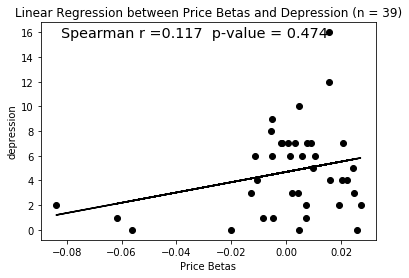

In [46]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept

plt.xlabel("Price Betas")
plt.ylabel("depression")

plt.plot(x,y,'o',x,line,color = 'black')
plt.title('Linear Regression between Price Betas and Depression (n = 39)')
plt.annotate('Spearman r =0.117  p-value = 0.474', xy=(0.06, 0.93), xycoords='axes fraction', size = 'x-large')

plt.savefig('figure/combined/price_depression_v2.0.png', transparent=True, dpi=300)
#plt.scatter(x, y, linewidth=2, color='purple', linestyle='-', marker='o', label="y=x^2")

### env & depression

In [47]:
x = corr['environment_binary[T.1]']
y = corr['depression']
ss.spearmanr(x,y)

SpearmanrResult(correlation=-0.073856788973465, pvalue=0.6549904901055081)

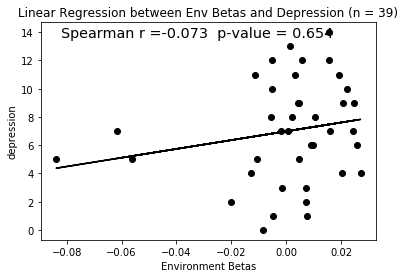

In [59]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept

plt.xlabel("Environment Betas")
plt.ylabel("depression")

plt.plot(x,y,'o',x,line,color = 'black')
plt.title('Linear Regression between Env Betas and Depression (n = 39)')
plt.annotate('Spearman r =-0.073  p-value = 0.654', xy=(0.06, 0.93), xycoords='axes fraction', size = 'x-large')

plt.savefig('figure/combined/env_depression_v2.0.png', transparent=True, dpi=300)
#plt.scatter(x, y, linewidth=2, color='purple', linestyle='-', marker='o', label="y=x^2")

In [49]:
x = corr['price_displayed']
y = corr['anxiety']
ss.spearmanr(x,y)

SpearmanrResult(correlation=0.18369308999545259, pvalue=0.26297061722841475)

In [133]:
x = corr['environment_binary[T.1]']
y = corr['anxiety']
ss.spearmanr(x,y)

SpearmanrResult(correlation=0.0, pvalue=1.0)

# Visualization

In [51]:
(corr.bAMI).describe()

count   39.000
mean     1.786
std      0.759
min      0.500
25%      1.250
50%      1.667
75%      2.167
max      3.667
Name: bAMI, dtype: float64

In [54]:
len(corr[corr['bAMI']>2.34])

7

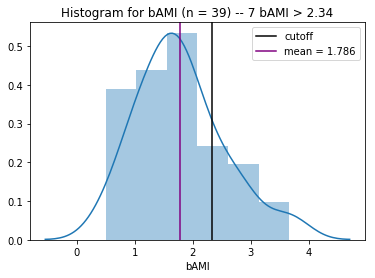

In [58]:
sns.distplot(corr.bAMI)
plt.title('Histogram for bAMI (n = 39) -- 7 bAMI > 2.34')
plt.axvline(x = 2.34, color = 'black', label = 'cutoff')
plt.axvline(x = 1.786, color = 'purple', label = 'mean = 1.786')
plt.legend()
plt.savefig('figure/combined/bAMI_39_v2.0.png', transparent=True, dpi=300)

# Heatmap

In [104]:
heat_map = scale.drop('id', axis = 1)

In [105]:
def compute_corr_and_p(df1, df2):
    corrs = pd.DataFrame(index=df1.columns, columns=df2.columns, dtype=np.float64)
    pvals = corrs.copy()
    for i, j in product(df1.columns, df2.columns):
        corrs.loc[i,j], pvals.loc[i,j] = ss.pearsonr(df1[i], df2[j])
    return corrs, pvals

def plot(corrs, pvals, siglevel=.01):
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask) | (pvals >= siglevel) ] = True
    
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    sns.heatmap(corrs, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5,
           cbar_kws={'shrink': .5})

In [106]:
corrs, pvals = compute_corr_and_p(heat_map, heat_map)

In [107]:
mask = np.zeros_like(corrs, dtype=np.bool)

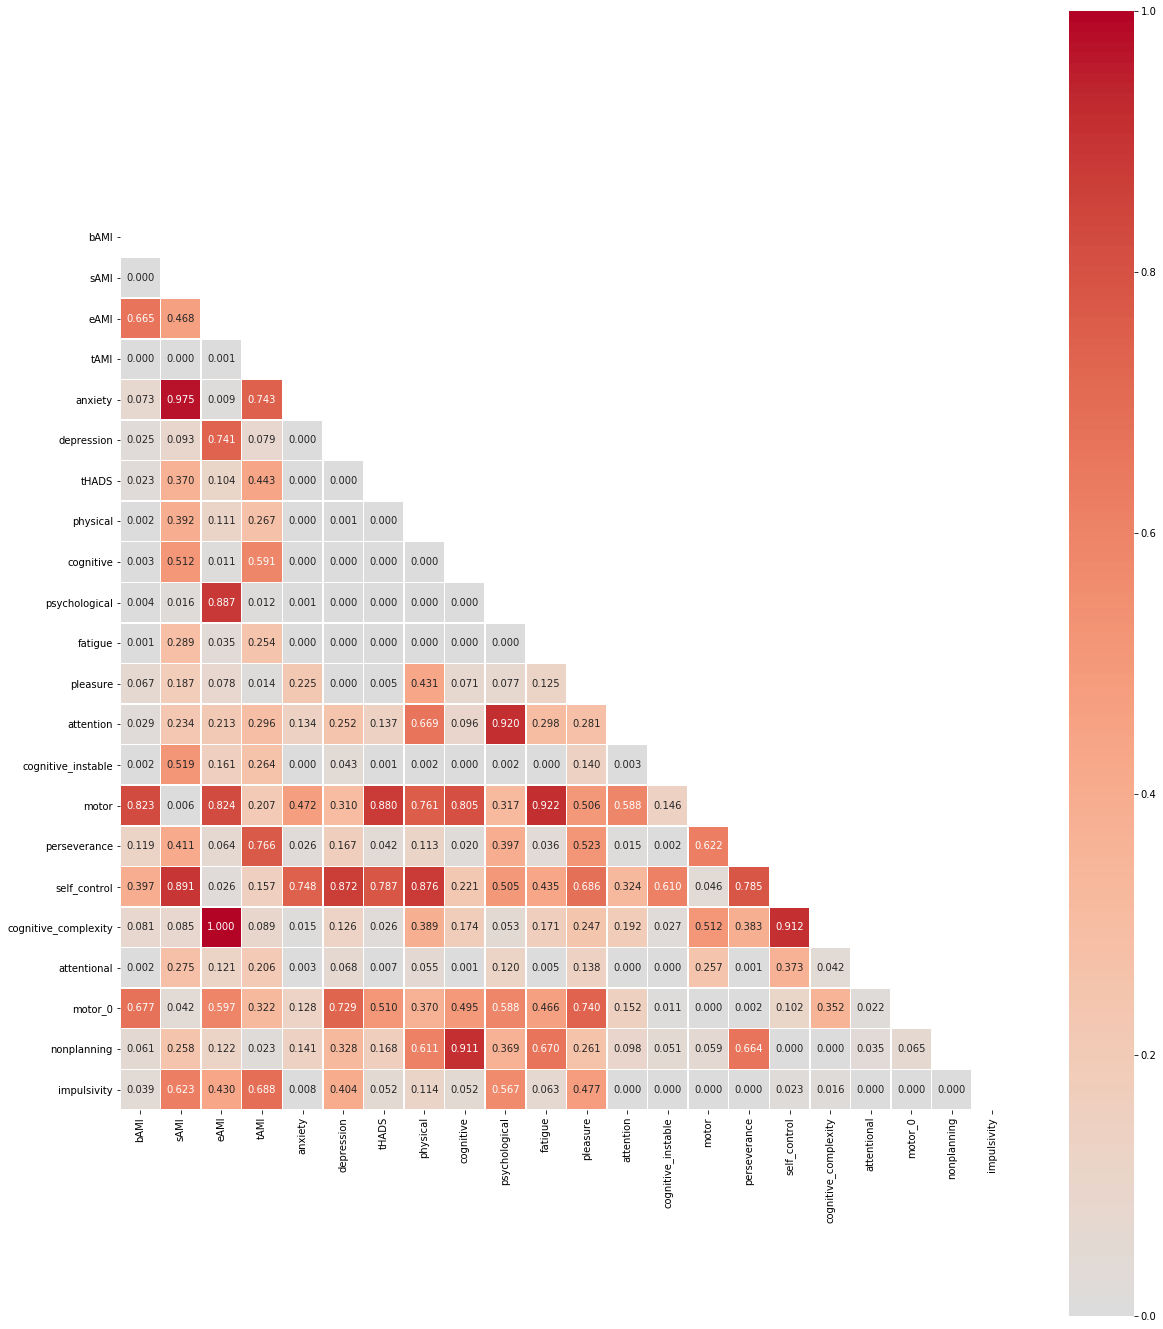

In [108]:
plt.figure(figsize=(20, 24))
mask[np.triu_indices_from(pvals)] = True
ax = sns.heatmap(
    pvals, 
    vmin=0.0000001, vmax=1, center=0,
    cmap='coolwarm',
    square=True,
    annot=True, linewidths=.5, fmt = '.3f', mask = mask
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='center'
);


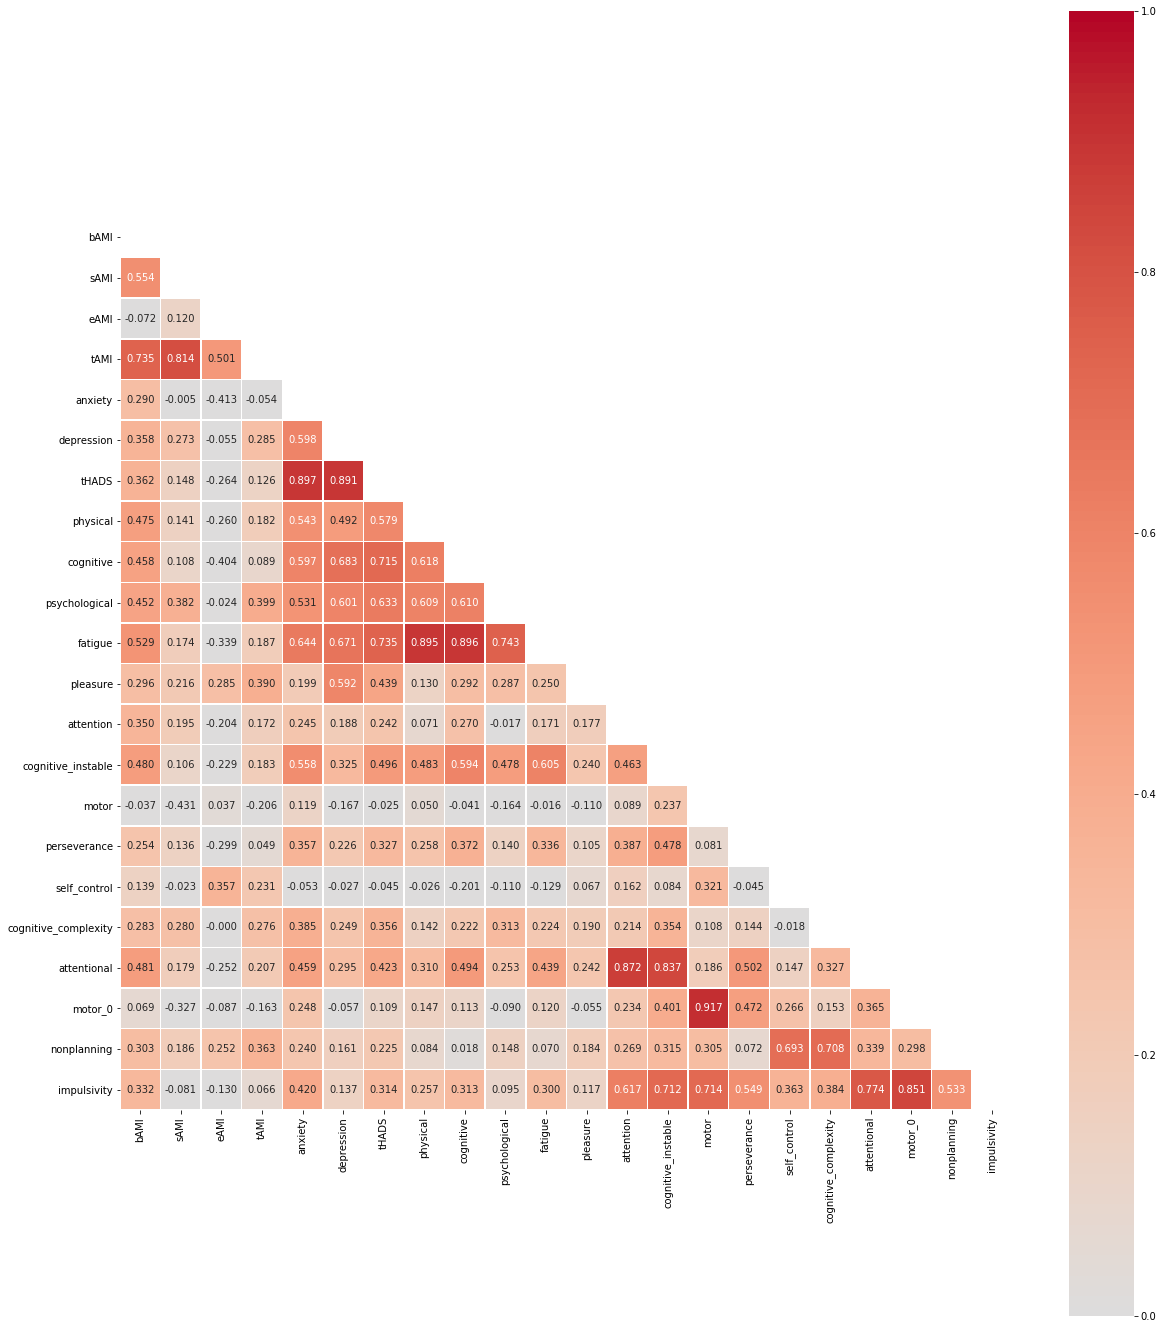

In [109]:
plt.figure(figsize=(20, 24))
mask[np.triu_indices_from(pvals)] = True
ax = sns.heatmap(
    corrs, 
    vmin=0.0000001, vmax=1, center=0,
    cmap='coolwarm',
    square=True,
    annot=True, linewidths=.5, fmt = '.3f', mask = mask
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='center'
);

# With interaction effect

In [166]:
random_effects_1 = random_effects_1.reset_index()

In [167]:
random_effects_1['id'] = random_effects_1['index']

In [168]:
corr_1 = pd.merge(scale, random_effects_1, on = ['id'], how = 'inner')

In [170]:
x = corr['price_displayed']
y = corr['bAMI']
ss.spearmanr(x,y)

SpearmanrResult(correlation=-0.37662359093611913, pvalue=0.01811558750936537)

In [171]:
x_1 = corr_1['price_displayed']
y_1 = corr_1['bAMI']
ss.spearmanr(x_1,y_1)

SpearmanrResult(correlation=-0.2782236891746715, pvalue=0.08634114668252879)

# Check for bugs

In [172]:
corr.head(100)

,id,bAMI,sAMI,eAMI,tAMI,anxiety,depression,tHADS,physical,cognitive,psychological,fatigue_x,pleasure,attention,cognitive_instable,motor,perseverance,self_control,cognitive_complexity,attentional,motor_0,nonplanning,impulsivity,index,Group,environment_binary[T.1],price_displayed,fatigue_y
0,765957.000,1.000,1.667,1.167,1.278,11,7,18,13,14,3,30,20,9,7,18,6,2,2,16,24,4,44,765957,0.041,0.027,0.003,-0.000
1,765963.000,2.000,1.500,1.833,1.778,9,10,19,18,20,4,42,45,6,6,14,6,2,2,12,20,4,36,765963,0.202,-0.250,0.005,0.000
2,765965.000,2.000,1.667,1.500,1.722,12,9,21,17,20,3,40,29,6,7,17,6,2,3,13,23,5,41,765965,0.031,0.009,-0.005,0.000
3,765970.000,1.667,1.667,0.833,1.389,6,5,11,13,15,4,32,22,4,5,17,4,2,2,9,21,4,34,765970,0.043,0.024,0.010,0.000
4,765973.000,1.833,2.000,0.667,1.500,7,5,12,6,17,3,26,27,5,5,12,4,2,2,10,16,4,30,765973,-0.055,0.080,0.024,0.000
5,765978.000,0.500,0.833,1.000,0.778,6,0,6,4,9,0,13,19,3,5,15,3,2,1,8,18,3,29,765978,0.096,-0.112,0.026,-0.000
6,765982.000,0.833,1.333,1.000,1.056,9,3,12,10,11,4,25,19,5,6,12,6,1,1,11,18,2,31,765982,-0.069,0.107,0.025,-0.000
7,765983.000,0.500,0.167,0.167,0.278,9,3,12,25,23,3,51,17,4,8,18,5,2,1,12,23,3,38,765983,-0.121,0.075,0.004,0.000
8,765985.000,1.833,2.667,1.333,1.944,12,12,24,14,18,4,36,25,5,4,13,4,3,2,9,17,5,31,765985,0.047,-0.021,0.016,-0.000
9,765987.000,1.000,0.500,1.833,1.111,3,1,4,12,10,1,23,20,3,4,18,5,2,1,7,23,3,33,765987,-0.173,0.071,0.007,-0.000


In [174]:
bAMI = corr.bAMI
price_betas = corr.price_displayed

In [175]:
ss.pearsonr(bAMI, price_betas)

(-0.2826554362872195, 0.0812458710550778)

In [183]:
ss.spearmanr(price_betas, bAMI)


SpearmanrResult(correlation=-0.37662359093611913, pvalue=0.01811558750936537)

In [182]:
ss.pearsonr(price_betas, corr.depression)

(0.27566824045177, 0.08938966724110824)